In [1]:
# Read Data
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
ticker_names= ["BTC-USD", "ETH-USD", "USDT-USD", "SOL-USD", "BNB-USD", \
           "XRP-USD", "STETH-USD", "USDC-USD", "ADA-USD", "AVAX-USD", \
           "DOGE-USD", "SHIB-USD", "DOT-USD", "TON11419-USD", "WTRX-USD", \
           "TRX-USD", "LINK-USD", "WBTC-USD", "MATIC-USD", "BCH-USD"]
dfs = []
X = []
Y = []

time_steps = 7

for name in ticker_names:  
    df = pd.read_csv(f'../DATA/Crypto Cleaned Data/cleaned_{name}_prices.csv')
    df = df.drop(columns=['Date'])
    df = df.drop(columns=['Volume'])
    scaler_of_df = MinMaxScaler(feature_range=(0,1))
    df_scaled = scaler_of_df.fit_transform(df)
    dfs.append(df_scaled)

    
    open = np.array(df_scaled[:, 0])
    high = np.array(df_scaled[:, 1])
    low = np.array(df_scaled[:, 2])
    close = np.array(df_scaled[:, 3])

    X_name = []
    Y_name = []
    

    for i in range(len(open)-time_steps-1):
        X_i = np.vstack((open[i:i+time_steps], high[i:i+time_steps], low[i:i+time_steps], close[i:i+time_steps])).T
        Y_i = close[i+time_steps]
        X_name.append(X_i)
        Y_name.append(Y_i)

    X_name = np.array(X_name)
    Y_name = np.array(Y_name)

    X.append(X_name)
    Y.append(Y_name)

X = np.array(X) # 3d arr: num_ticker * num_sample * num_features
Y = np.array(Y) # 2d arr: num_ticker * num_sample

X_trains = [] # 3d arr: ticker * sample * features
Y_trains = [] # 2d arr: ticker * sample
X_cvs = [] # 3d arr: ticker * sample * features
Y_cvs = [] # 2d arr: ticker * sample
X_tests = [] # 3d arr: ticker * sample * features
Y_tests = [] # 2d arr: ticker * sample

training_sizes = []
cv_sizes = []
test_sizes = []

for ticker in X:
    train_size = int(len(ticker) * 0.6)
    cv_size = int(len(ticker) * 0.2)
    test_size = len(ticker) - train_size - cv_size

    training_sizes.append(train_size)
    cv_sizes.append(cv_size)
    test_sizes.append(test_size)

    X_train = ticker[:train_size]
    X_cv = ticker[train_size:train_size+cv_size]
    X_test = ticker[train_size+cv_size:]

    X_trains.append(X_train)
    X_cvs.append(X_cv)
    X_tests.append(X_test)


for ticker in Y:
    train_size = int(len(ticker) * 0.6)
    cv_size = int(len(ticker) * 0.2)

    Y_train = ticker[:train_size]
    Y_cv = ticker[train_size:train_size+cv_size]
    Y_test = ticker[train_size+cv_size:]

    Y_trains.append(Y_train)
    Y_cvs.append(Y_cv)
    Y_tests.append(Y_test)


X_trains = np.array(X_trains) # 3d arr: ticker * sample * features
Y_trains = np.array(Y_trains) # 2d arr: ticker * sample
X_cvs = np.array(X_cvs) # 3d arr: ticker * sample * features
Y_cvs = np.array(Y_cvs) # 2d arr: ticker * sample
X_tests = np.array(X_tests) # 3d arr: ticker * sample * features
Y_tests = np.array(Y_tests) # 2d arr: ticker * sample


/var/folders/c1/t6c91th93rg_t8cmmzfjwp840000gn/T/ipykernel_19049/2754482071.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X) # 3d arr: num_ticker * num_sample * num_features
/var/folders/c1/t6c91th93rg_t8cmmzfjwp840000gn/T/ipykernel_19049/2754482071.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Y = np.array(Y) # 2d arr: num_ticker * num_sample
/var/folders/c1/t6c91th93rg_t8cmmzfjwp840000gn/T/ipykernel_19049/2754482071.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers.legacy import Adam
from keras.callbacks import EarlyStopping
import IPython

time_steps = 7 # a week of steps
input_dim = 4 # OHL

histories = []

for i in range(len(ticker_names)):
    x_t = X_trains[i]
    y_t = Y_trains[i]
    x_cv = X_cvs[i]
    y_cv = Y_cvs[i]

    # Define early stopping criteria
    early_stopping = EarlyStopping(monitor='val_loss',  # Or 'val_accuracy' depending on what you want to monitor
                                min_delta=0.001,  # Minimum change to qualify as an improvement
                                patience= 15,  # How many epochs to wait before stopping
                                restore_best_weights=True)  # Restore model weights from the epoch with the best value of the monitored quantity
    
    model = Sequential([   
        LSTM(units= 256, return_sequences=True, input_shape=(time_steps, input_dim)),
        LSTM(units= 128, return_sequences=False),
        Dense(units= 64, activation='relu'),
        Dense(units= 1, activation='linear'),
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
    history = model.fit(x_t, y_t, validation_data=(x_cv, y_cv) , epochs=100, batch_size=64, callbacks=[early_stopping])
    model.save(f'../cryp_mod/{ticker_names[i]}.h5')
    histories.append(history)

    IPython.display.clear_output()


In [4]:
import IPython
from keras.models import load_model
from tensorflow.keras.losses import mse


predictions = []
mses = []

for i in range(len(ticker_names)):
    model = load_model(f'../LSTM/cryp_mod/{ticker_names[i]}.h5')
    prediction = model.predict(X_tests[i])
    prediction = prediction.flatten()
    predictions.append(prediction)
    mses.append(float(mse(Y_tests[i], prediction)))
    IPython.display.clear_output()

print(f'Mean Squared Error: {mses}')


Mean Squared Error: [0.0013214309001341462, 0.000497921253554523, 0.0004088164132554084, 0.0007057888433337212, 0.0006182543002068996, 0.000173758584423922, 0.0016418034210801125, 0.000587809830904007, 0.00021927607303950936, 0.002912075025960803, 4.3778534745797515e-05, 0.0007862129132263362, 0.00023710390087217093, 0.0036771632730960846, 0.016466399654746056, 0.000763303367421031, 0.00018760215607471764, 0.00125566974747926, 0.0004908490809611976, 5.636325658997521e-05]


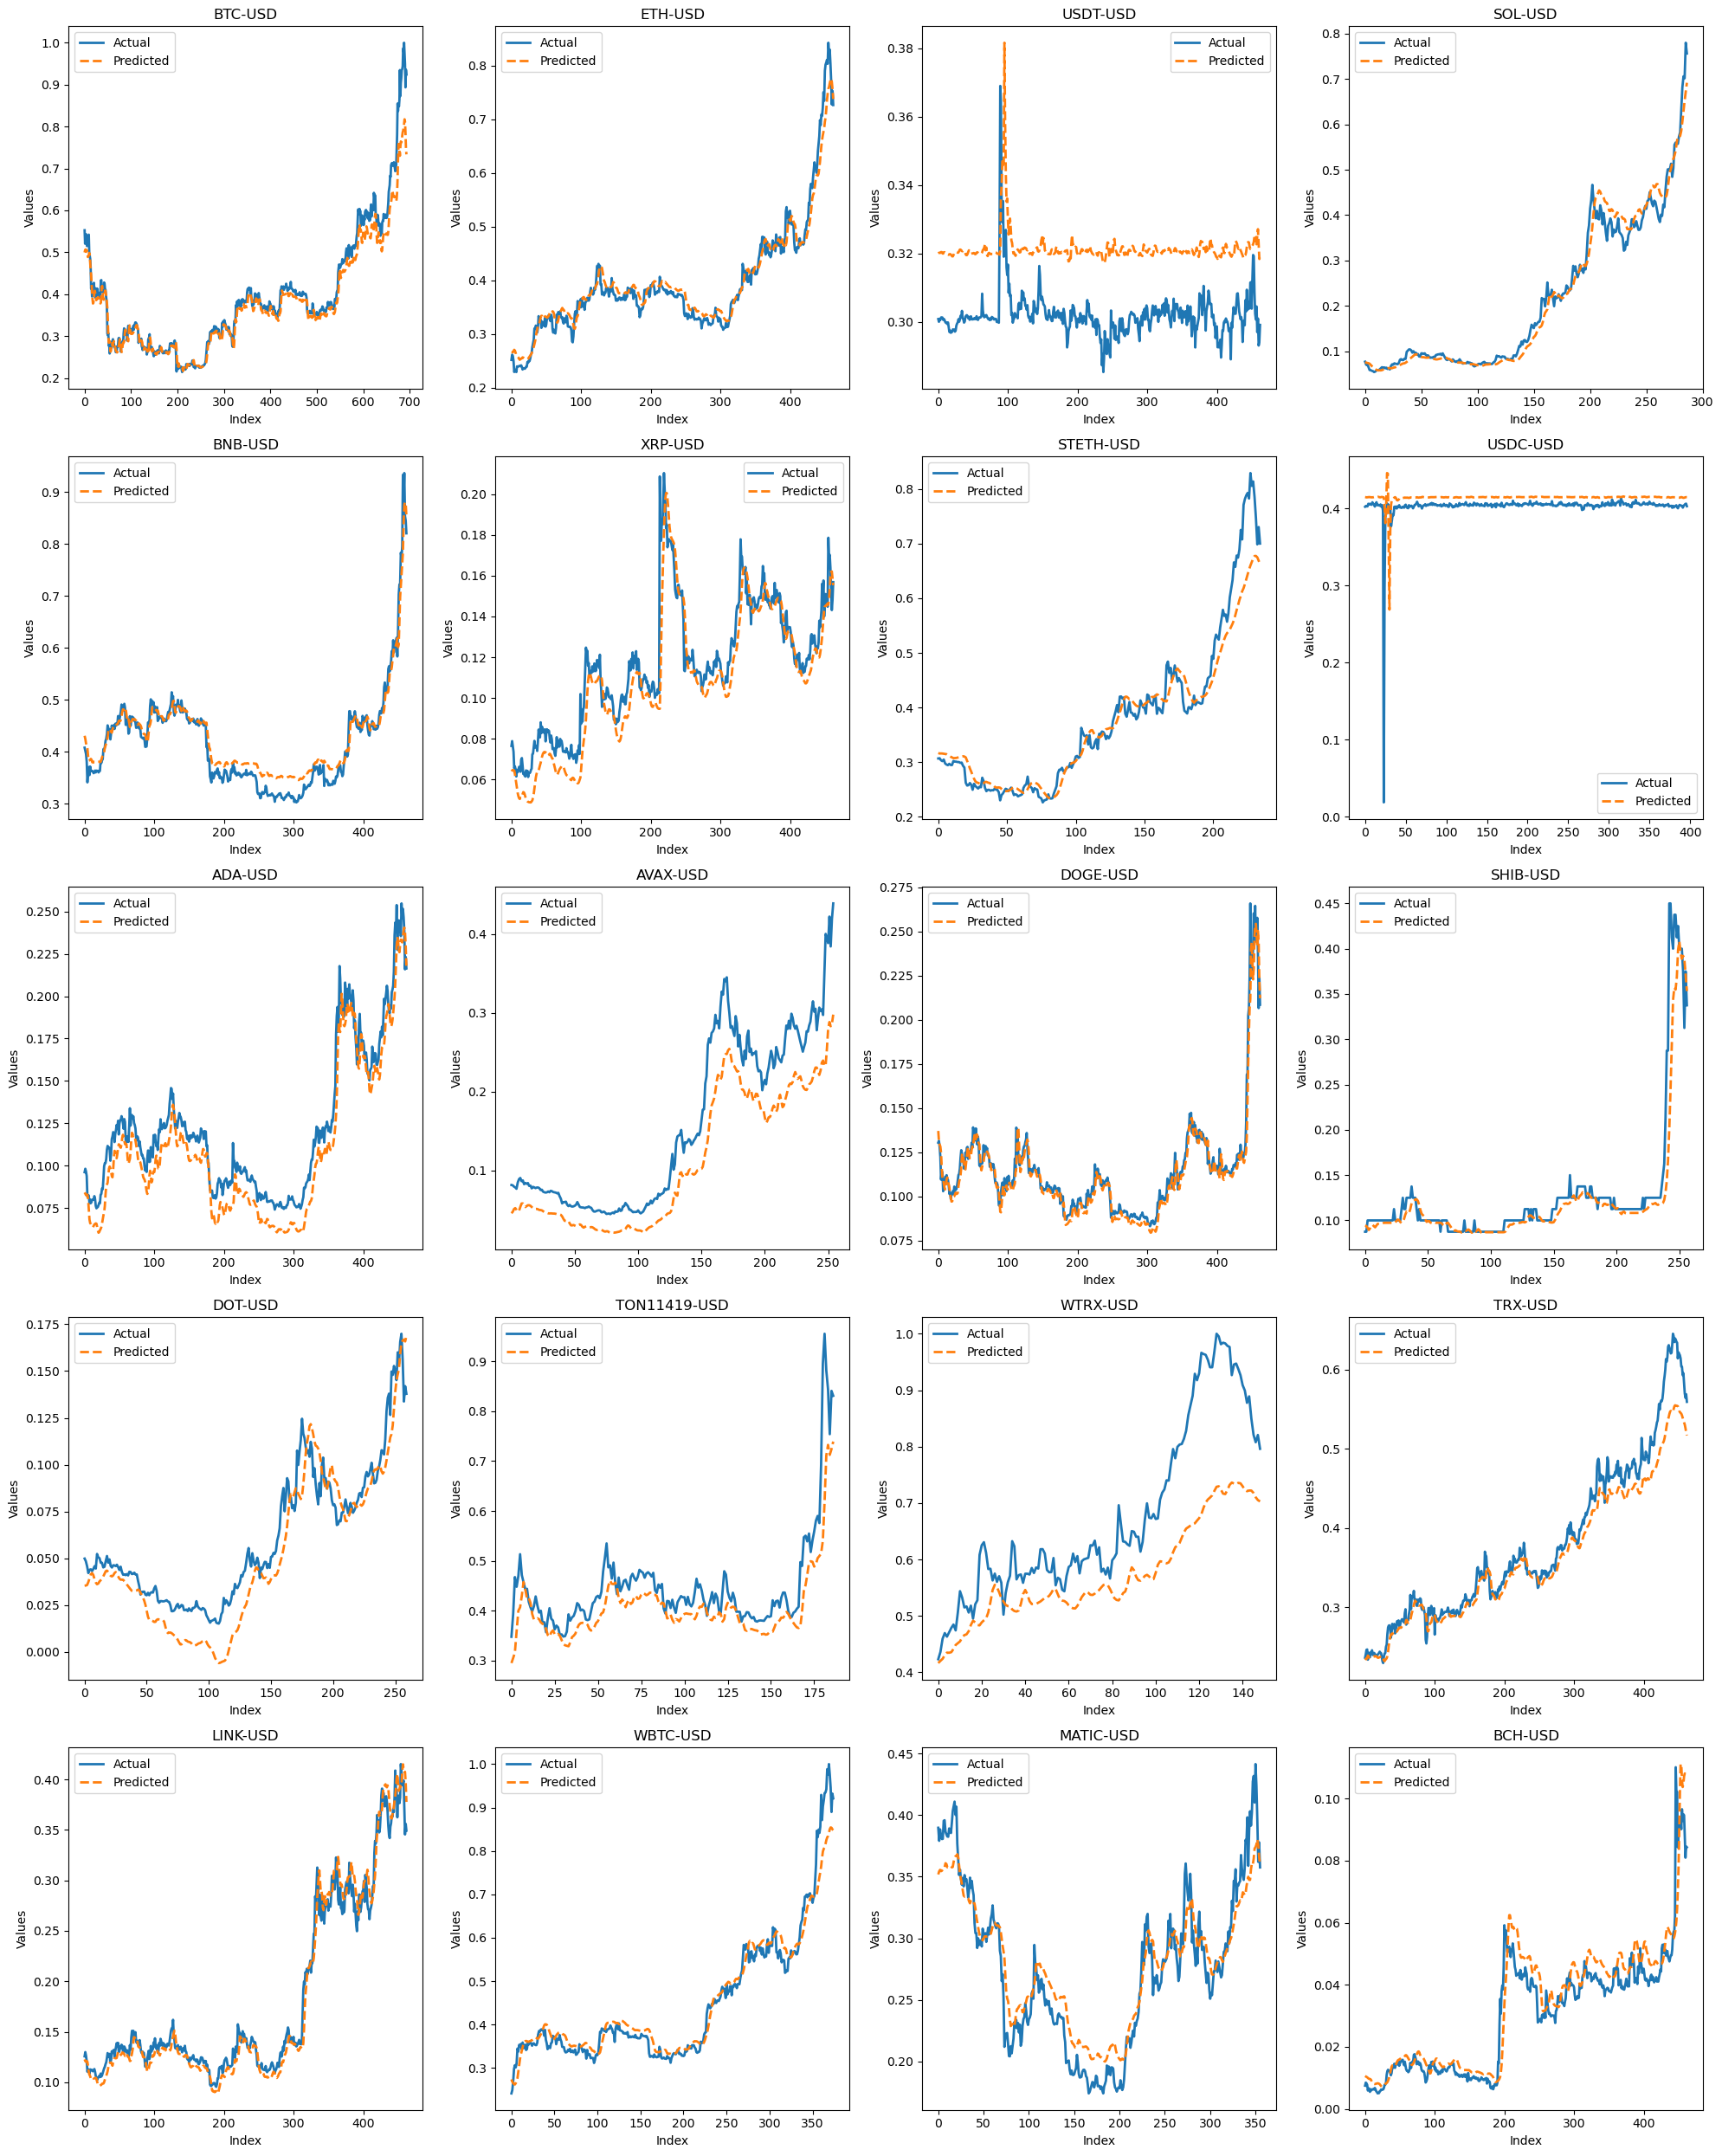

In [5]:
import matplotlib.pyplot as plt

# # Let's assume predictions and y_tests are already defined as described.
# predictions = [...]  # Replace [...] with your predictions list
# y_tests = [...]      # Replace [...] with your actual values, assumed to be a numpy array of numpy arrays

# Number of datasets
num_datasets = 20

# Setup the subplot dimensions (5 rows, 4 columns in this case)
fig, axes = plt.subplots(5, 4, figsize=(20, 25))  # Adjust the figsize as needed

# Loop through all datasets
for i in range(num_datasets):
    # Identify the correct subplot
    ax = axes[i // 4, i % 4]

    # Plot the actual values and predicted values
    ax.plot(Y_tests[i], label='Actual', linewidth=2)
    ax.plot(predictions[i], label='Predicted', linestyle='--', linewidth=2)

    # Formatting the graph
    ax.set_title(f'{ticker_names[i]}')
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()


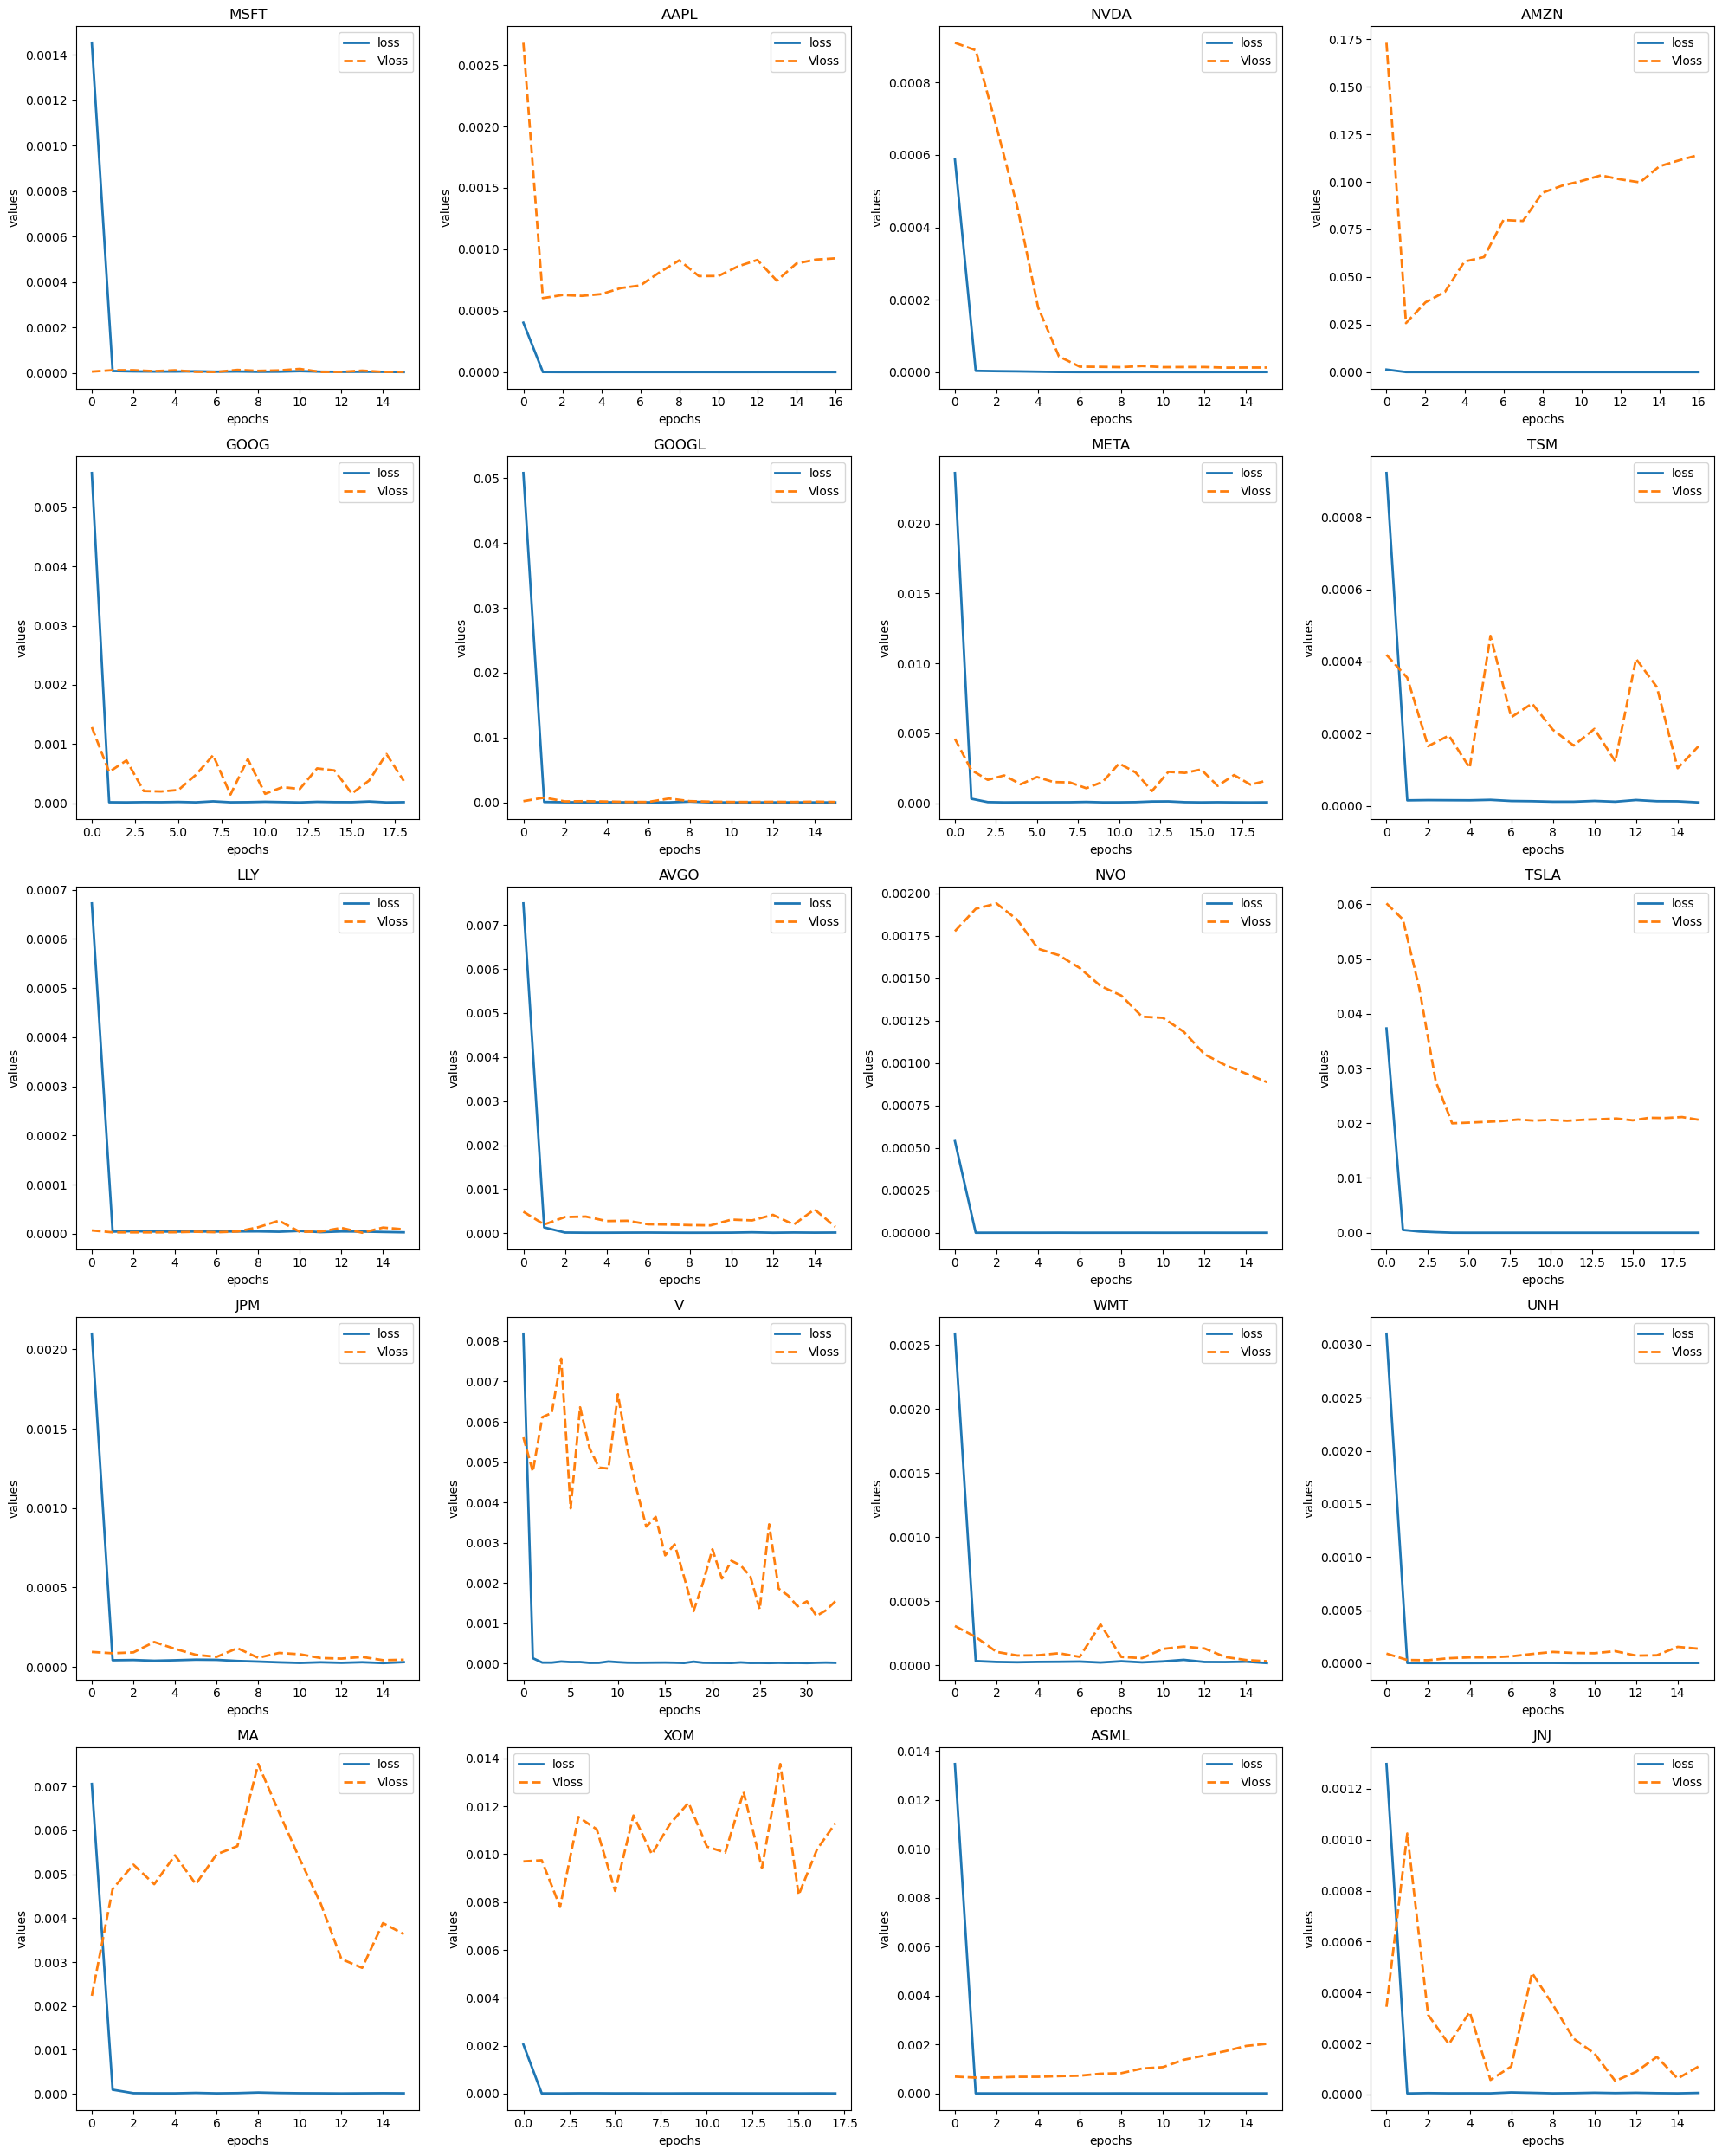

In [34]:
import matplotlib.pyplot as plt


import matplotlib.pyplot as plt

# # Let's assume predictions and y_tests are already defined as described.
# predictions = [...]  # Replace [...] with your predictions list
# y_tests = [...]      # Replace [...] with your actual values, assumed to be a numpy array of numpy arrays

# Number of datasets
num_datasets = 20

# Setup the subplot dimensions (5 rows, 4 columns in this case)
fig, axes = plt.subplots(5, 4, figsize=(20, 25))  # Adjust the figsize as needed

# Loop through all datasets
for i in range(num_datasets):
    # Identify the correct subplot
    ax = axes[i // 4, i % 4]

    historyi = histories[i]
    # Assuming 'history' is the history object returned from the 'fit()' method
    # Extract loss and validation loss
    loss = historyi.history['loss']
    val_loss = historyi.history.get('val_loss')  # 'None' if no validation loss

    # Create count of the number of epochs
    epochs = range(1, len(loss) + 1)

    # Plot the actual values and predicted values
    ax.plot(loss, label='loss', linewidth=2)
    ax.plot(val_loss, label='Vloss', linestyle='--', linewidth=2)

    # Formatting the graph
    ax.set_title(f'{ticker_names[i]}')
    ax.set_xlabel('epochs')
    ax.set_ylabel('values')
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()
